# Time Series Anamoly Detection using LSTM Autoencoders with PyTorch in Python

In [37]:
%pip install liac-arff
# reads .arff files (Attribute Relation File Format)
# converts them into Python data structures to turn into pandas DataFrames

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/110.9 MB ? eta -:--:--
    --------------------------------------- 2.4/110.9 MB 8.6 MB/s eta 0:00:13
   - -------------------------------------- 5.0/110.9 MB 10.4 MB/s eta 0:00:11
   -- ------------------------------------- 7.6/110.9 MB 11.1 MB/s eta 0:00:10
   --- ------------------------------------ 9.4/110.9 MB 10.6 MB/s eta 0:00:10
   ---- ----------------------------------- 11.8/110.9 MB 10.6 MB/s eta 0:00:10
   ----- ---------------------------------- 13.9/110.9 MB 10.7 MB/s eta 0:00:10
   ----- ---------------------------------- 16.5/110.9 MB 10.9 MB/s eta 0:00:09
   ------ --------------------------------- 18.6/110.9 MB 10.9 MB/s eta 0:00:09
   ------- -------------------------------- 20.4/110.9 MB 10.6 MB/s eta 0:00:09
   -------- ------------------------------- 22.5/110.9 MB 10.6 MB

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [18]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
from pathlib import Path

In [20]:
from torch import nn, optim

In [23]:
import torch.nn.functional as F
import arff

In [42]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [41]:
def load_arff_as_dataframe(path: str | Path) -> pd.DataFrame:
    path = Path(path)
    with path.open("r") as f:
        d = arff.load(f)

    # column names come from the "attributes" section
    cols = [name for name, _dtype in d["attributes"]]

    # rows come from the "data" section
    df = pd.DataFrame(d["data"], columns=cols)

    return df

In [43]:
train = load_arff_as_dataframe("ECG5000/ECG5000_TRAIN.arff")
test  = load_arff_as_dataframe("ECG5000/ECG5000_TEST.arff")

train.shape, test.shape

((500, 141), (4500, 141))

In [45]:
df = pd.concat([train, test], ignore_index=True)
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

df.shape

(5000, 141)

In [47]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
1,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
3,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
4,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1


In [49]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

In [51]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [53]:
df.target.value_counts()

target
1    2919
2    1767
4     194
3      96
5      24
Name: count, dtype: int64

C:\Users\DSU Student\AppData\Local\Temp\ipykernel_38984\1621058309.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="target", data=df, palette = "Set2")


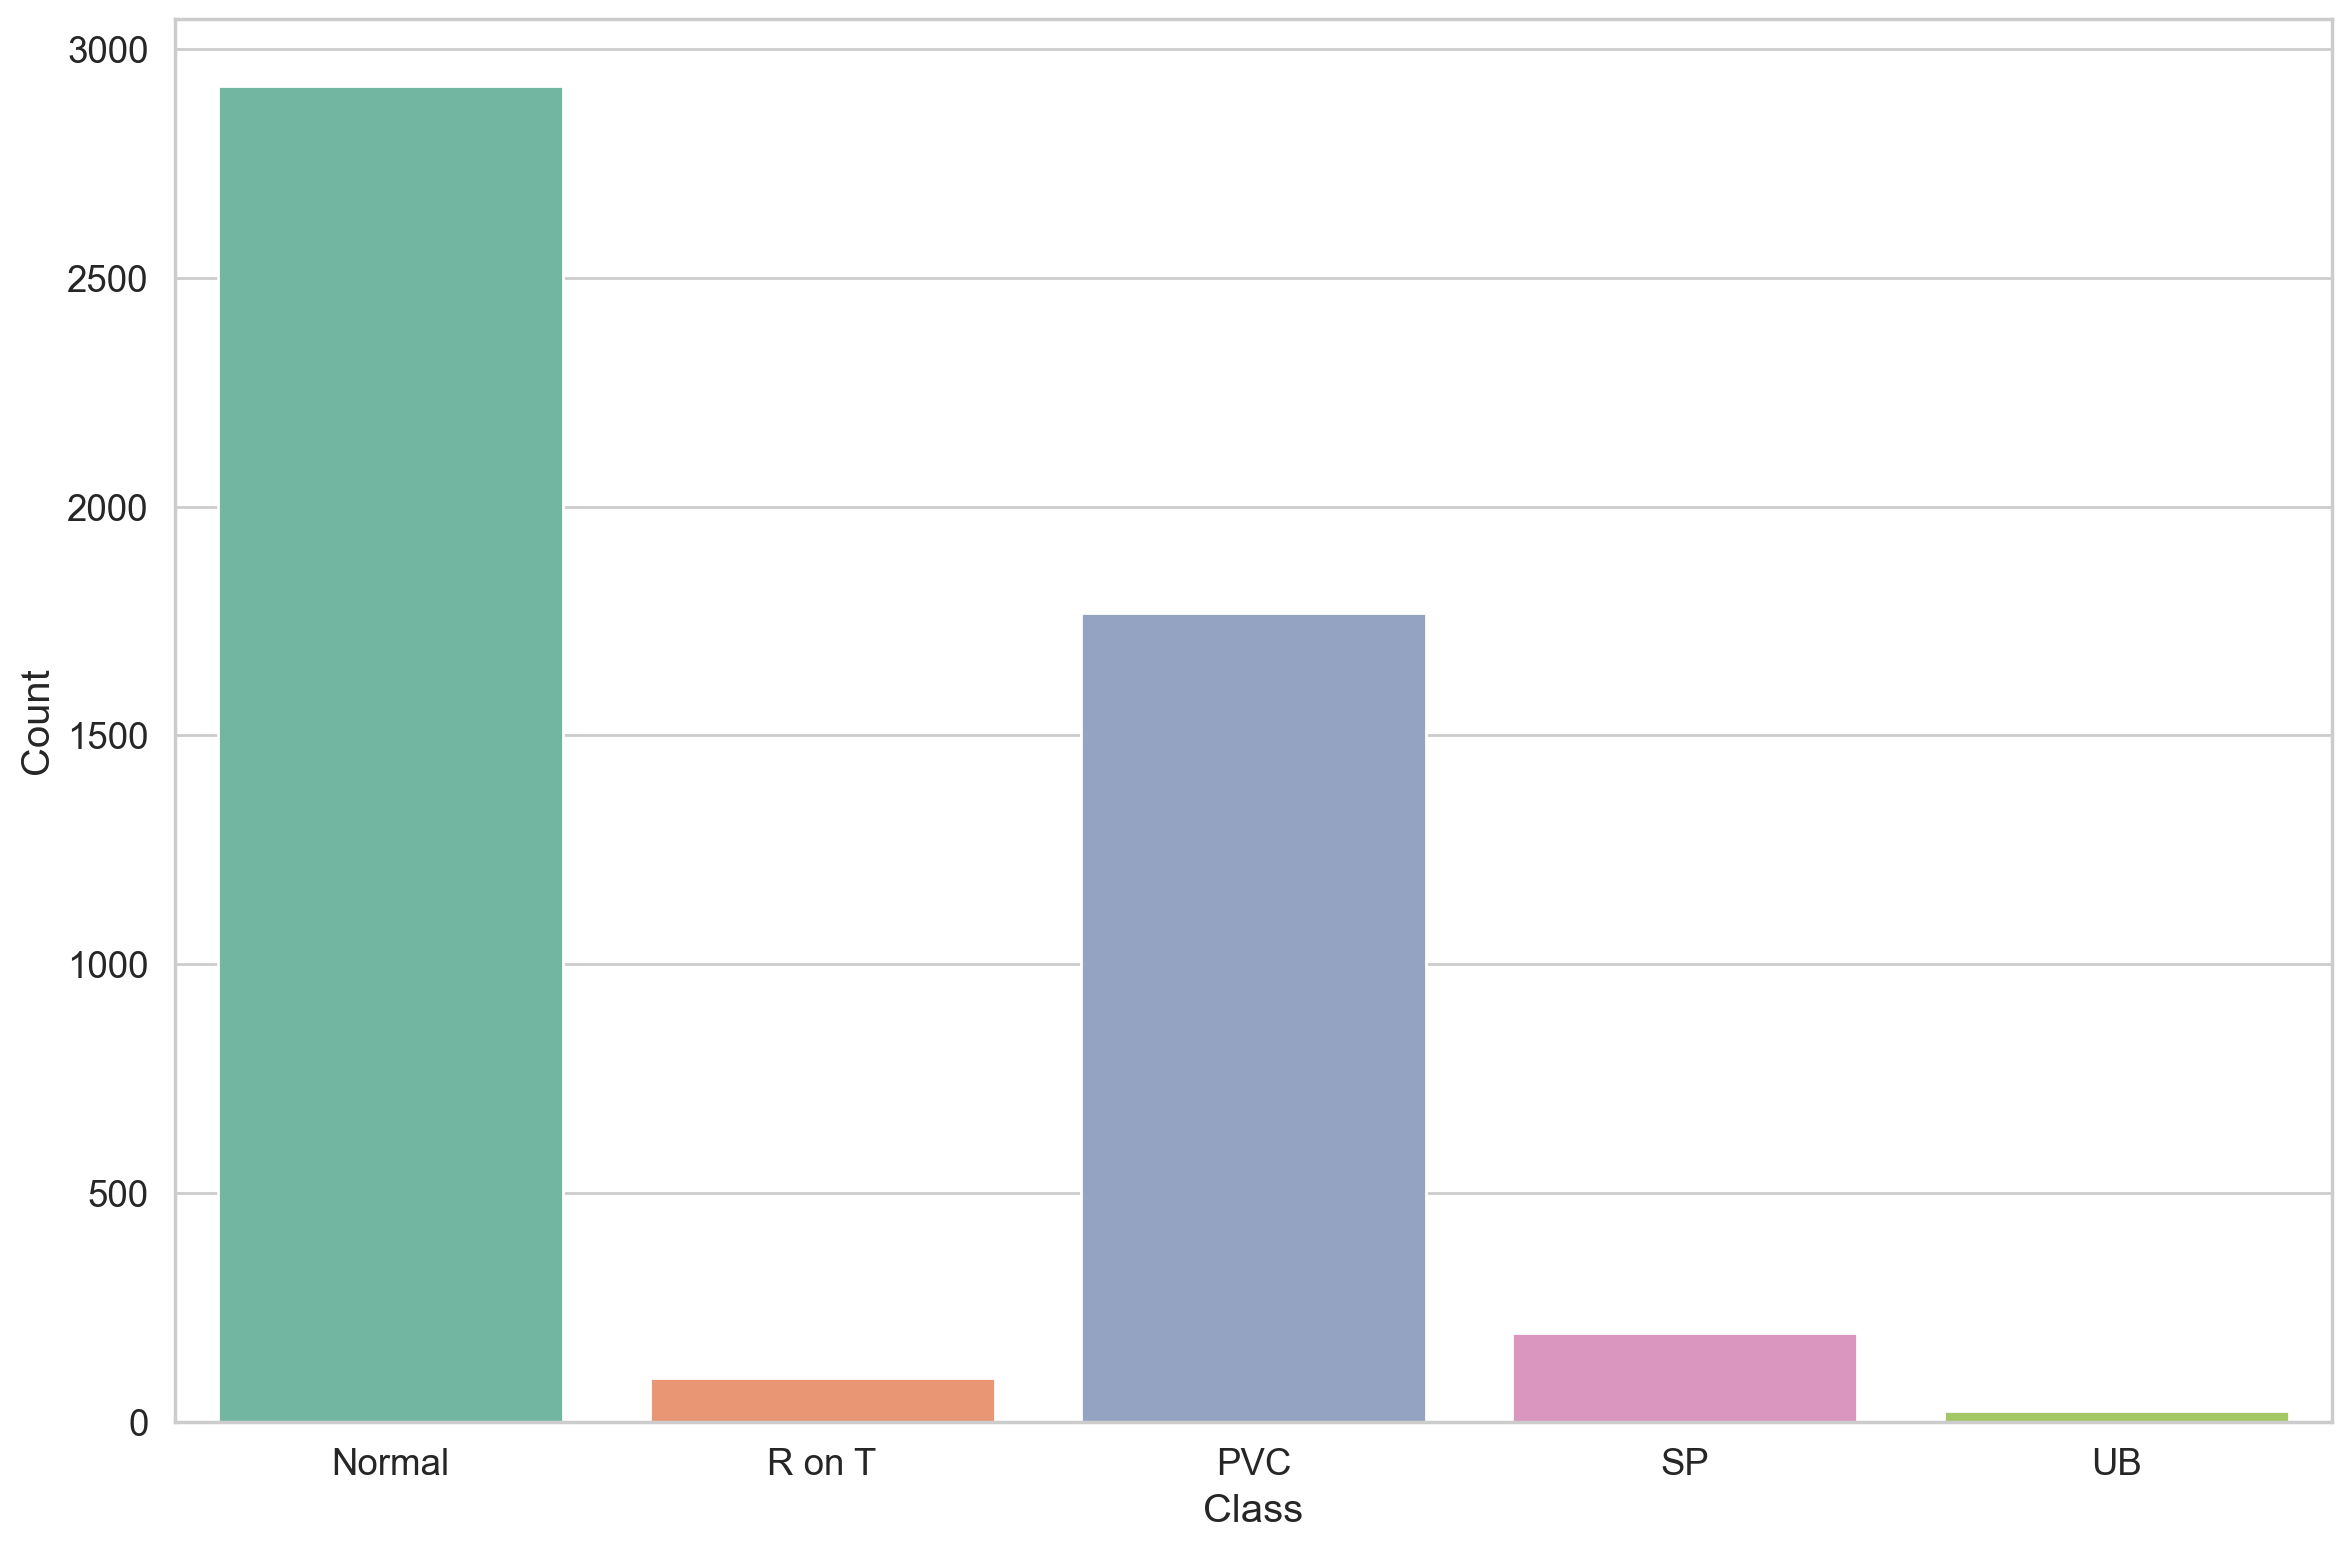

In [58]:
ax = sns.countplot(x="target", data=df, palette = "Set2")

# set tick positions FIRST
ax.set_xticks(range(len(class_names)))

# then set tick labels
ax.set_xticklabels(class_names)

ax.set_xlabel("Class")
ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [60]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

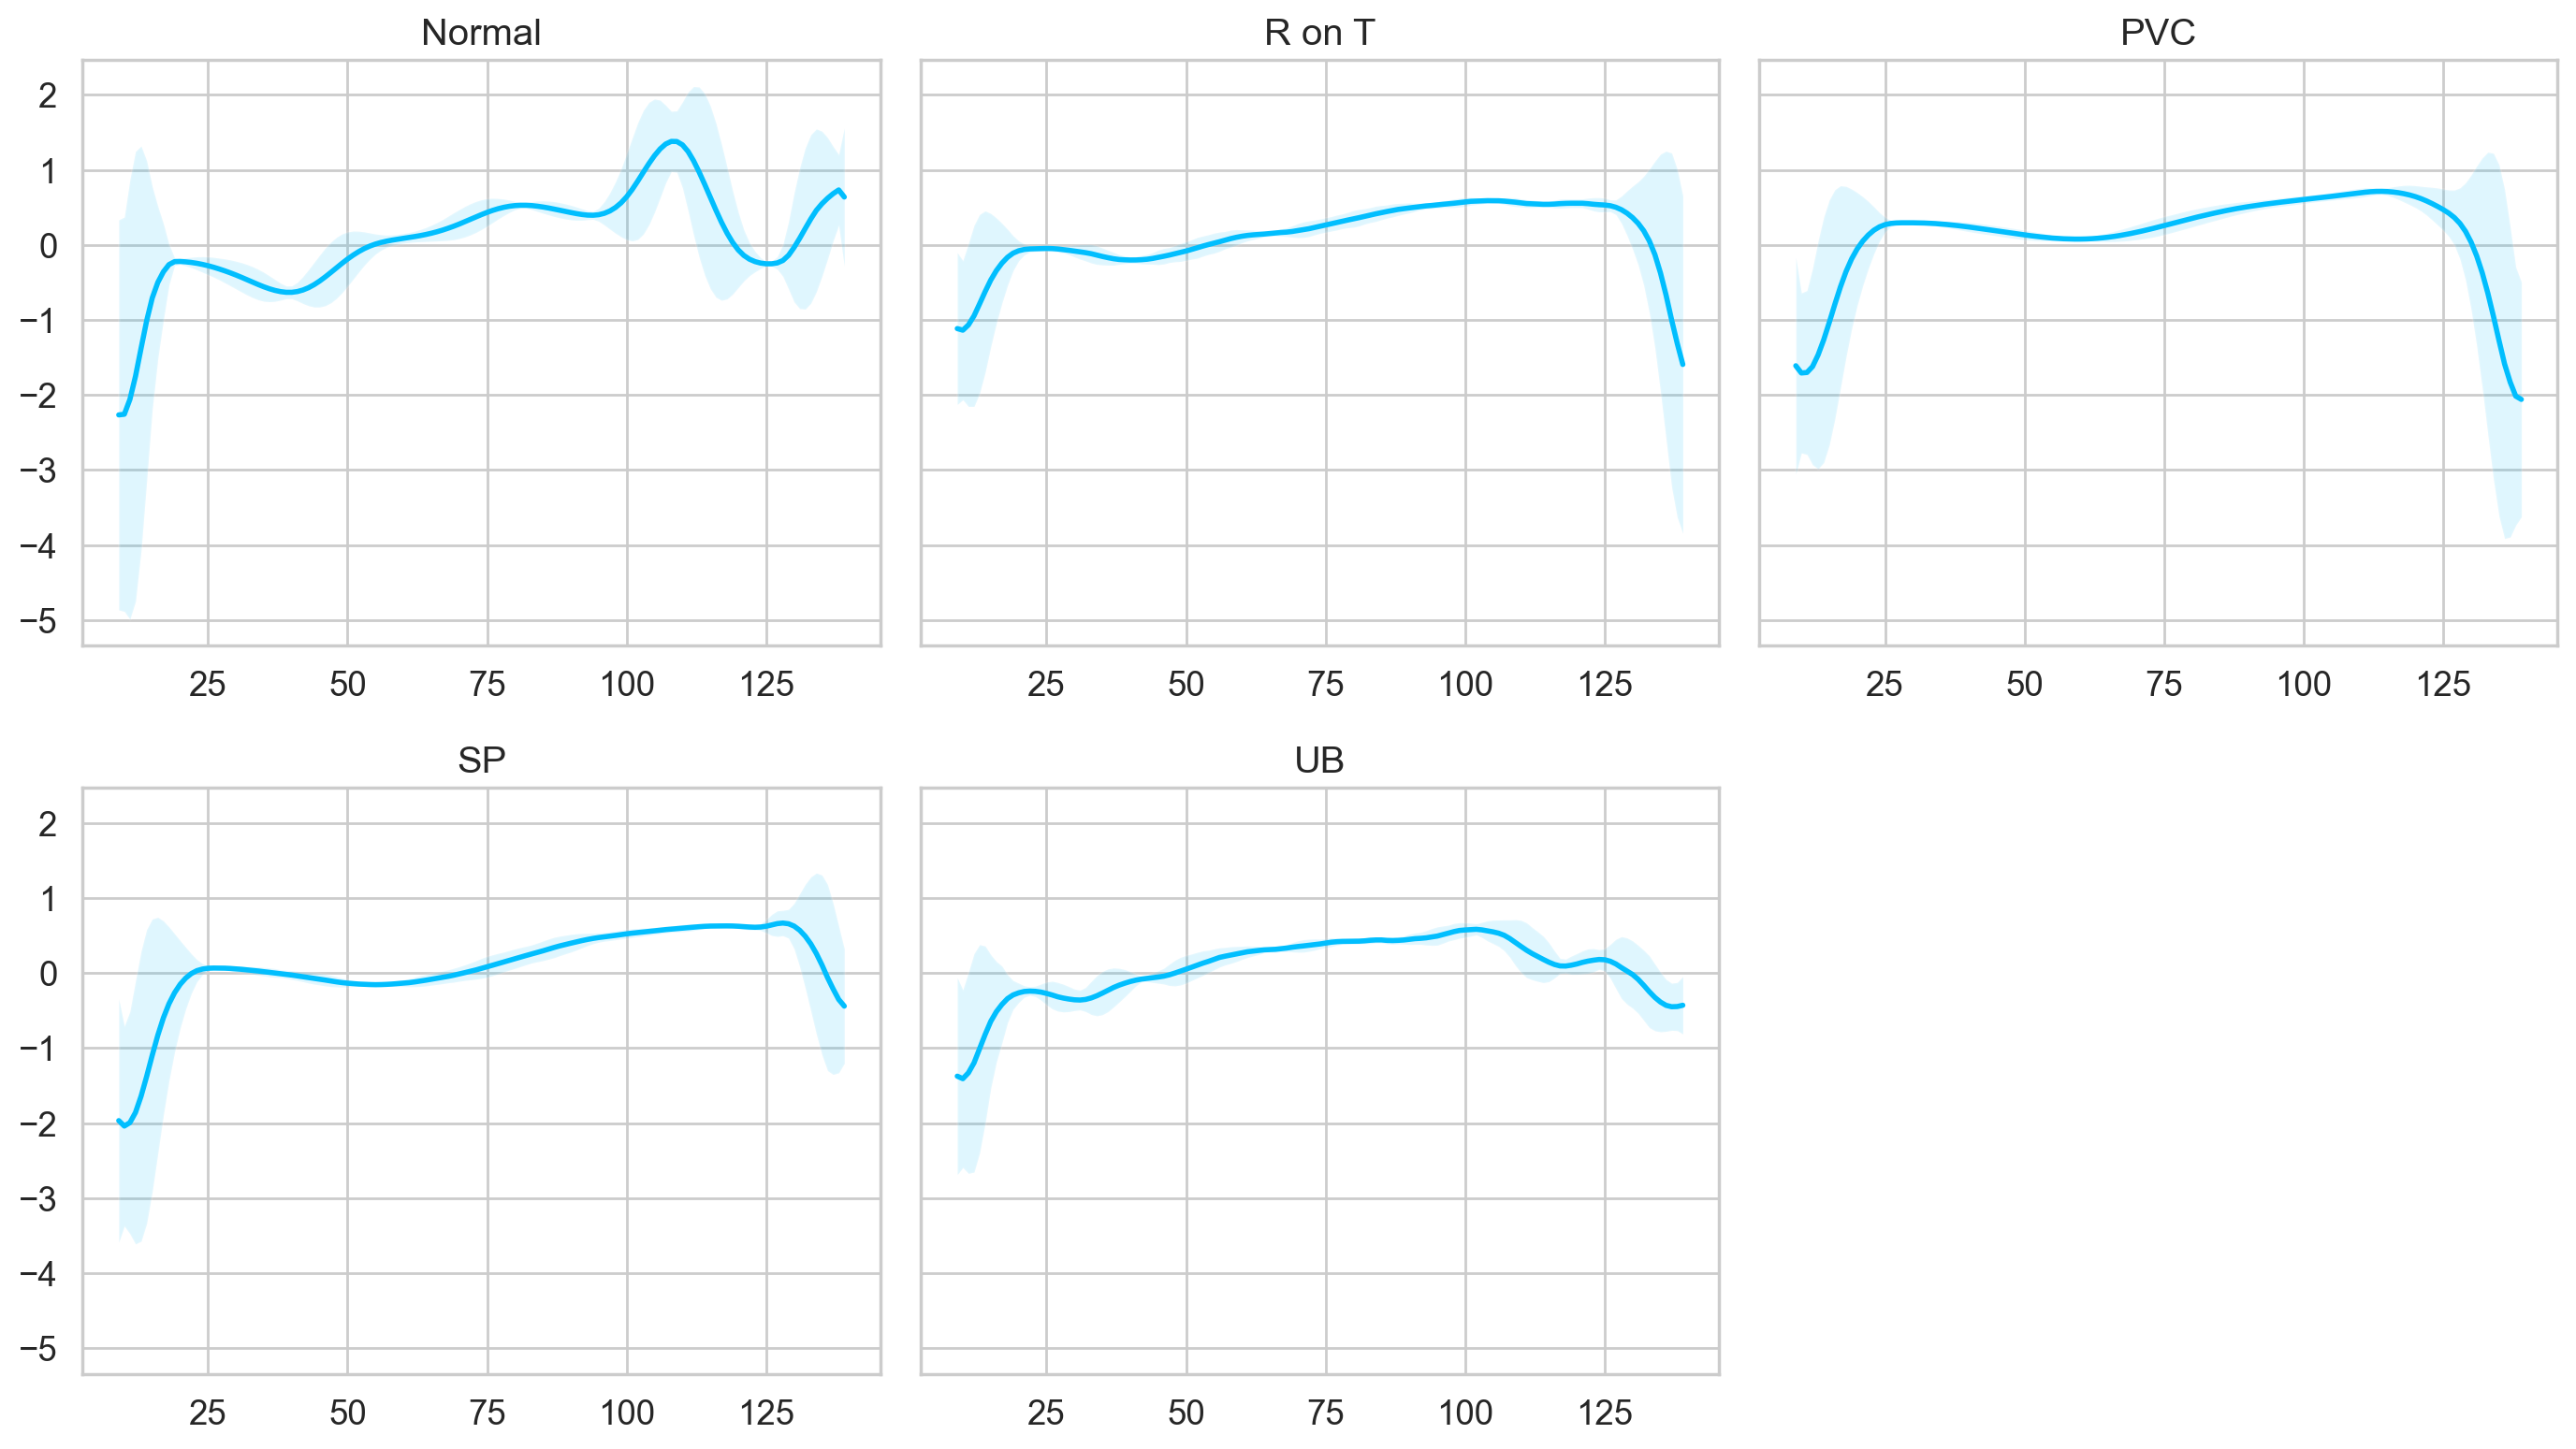

In [63]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout()

In [65]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [67]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [69]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [ ]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy()
    x = torch.tensor(sequences).unsqueeze(-1)   # (n_seq, seq_len, 1)
    n_seq, seq_len, n_features = x.shape
    return x, seq_len, n_features

In [73]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [75]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [77]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [79]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [83]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [1]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [2]:
import torch
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

cuda available: False
